
# Chest X-Ray Image Classification Ensemble Model

## Overview
This notebook implements an ensemble of multiple trained models to improve classification performance on chest x-ray images across 14 medical conditions. The ensemble approach combines predictions from models trained with different hyperparameters to achieve better overall performance than any single model.

## Process

### 1. Load Individual Models
Five models were loaded with varying configurations:
- Baseline model
- Model trained with batch_size=16, learning_rate=3e-5
- Model trained with batch_size=64
- Model trained with batch_size=128 
- Model trained with DynamicWeightedBCE_combo loss function

### 2. Generate Predictions
Each model generated predictions on the test dataset (5,555 images). The predictions were collected using:
```python
model = create_ensemble_model()
model.load_weights(model_file)
predictions = model.predict(test_dataset)
```

### 3. Ensemble Method
Predictions from all models were combined using simple averaging:
```python
ensemble_predictions = np.mean(all_predictions, axis=0)
```

### 4. Performance Evaluation
The ensemble predictions were evaluated using:
- ROC AUC scores for each condition
- Precision-recall curves
- Optimal thresholds determined by F1 score maximization

## Results
The ensemble achieved superior performance compared to individual models:
- Mean AUC: 0.842 (previous best: 0.834)
- Standard deviation: 0.061
- Top performing conditions:
  - Cardiomegaly: 0.915
  - Emphysema: 0.913
  - Edema: 0.899

## Next Steps
- Experiment with weighted averaging based on model performance
- Analyze individual model contributions
- Save ensemble predictions for future use
```

In [1]:
import time

# Start timer
start_time = time.time()

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2025-01-10 06:00:42.522138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 06:00:42.538206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 06:00:42.543268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 06:00:42.555364: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1736514046.300675    81

In [3]:
import os
import io
import sys
import random
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from datetime import datetime


In [4]:
import os
import random

random_state=17

random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)
tf.keras.utils.set_random_seed(random_state)
os.environ['PYTHONHASHSEED'] = str(random_state)

In [5]:
!sudo timedatectl set-timezone US/Mountain

In [6]:
import pickle


with open('saved_variables/data_files.pkl', 'rb') as f:
    data_files = pickle.load(f)

for key, value in data_files.items():
    if key.startswith('df_'):
        # For dataframes, print head(2) instead of full frame
        print(f"\n{key}:")
        print(f"{value.shape})")
        display(value.head(2))
    elif key == 'y_true' and isinstance(value, (list, tuple, np.ndarray)):
        # If 'y_true' is found, display its shape
        print(f"\n{key:<25} shape = {value.shape}")
    else:
        # For other variables, print normally
        print(f"{key:<25} = {value}")

for key, value in data_files.items():
    globals()[key] = value

target_w                  = 320
target_h                  = 320
input_shape               = (320, 320, 3)
target_size               = (320, 320)
dataset_size              = 112120
local_image_directory     = nih_xrays_320
num_labels                = 14
label_text                = ['Infiltration', 'Effusion', 'Atelectasis', 'Nodule', 'Mass', 'Pneumothorax', 'Consolidation', 'Pleural_Thickening', 'Cardiomegaly', 'Emphysema', 'Edema', 'Fibrosis', 'Pneumonia', 'Hernia']
y_pred_threshold_gt       = 0.5

df_train:
(101136, 16))


,Image,PatientId,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pneumothorax,Consolidation,Pleural_Thickening,Cardiomegaly,Emphysema,Edema,Fibrosis,Pneumonia,Hernia
0,00001249_010.png,1249,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,00029173_000.png,29173,0,0,0,0,0,0,0,0,0,0,0,0,0,0



df_val:
(5429, 16))


,Image,PatientId,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pneumothorax,Consolidation,Pleural_Thickening,Cardiomegaly,Emphysema,Edema,Fibrosis,Pneumonia,Hernia
1,00018521_004.png,18521,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72,00016429_012.png,16429,0,0,0,0,0,1,0,0,0,0,0,0,0,0



df_test:
(5555, 16))


,Image,PatientId,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pneumothorax,Consolidation,Pleural_Thickening,Cardiomegaly,Emphysema,Edema,Fibrosis,Pneumonia,Hernia
15,00020057_000.png,20057,0,0,0,0,0,0,0,0,0,1,0,0,0,0
40,00025085_018.png,25085,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Weighted Loss Functions, Model, Metrics, Callbacks

In [7]:
from train_ensemble_utilities import *

I0000 00:00:1736514047.020867    8101 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736514047.022660    8101 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736514047.024381    8101 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736514047.142932    8101 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# Recreate test_dataset

In [8]:
PRED_BATCH_SIZE = 16 

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    try:
        img = tf.image.decode_png(img, channels=3)
    except:
        raise
    
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [320, 320])
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img

def create_subset_data(df, n_samples, random_state=42):
    """Create a smaller subset of the data"""
    # return df.sample(n=n_samples, random_state=random_state)
    return df.head(n_samples)

def create_dataset(df, img_dir, batch_size=PRED_BATCH_SIZE, shuffle_buffer=1000, cache=False):
    """Create a TensorFlow dataset from DataFrame"""
    # Create full image paths
    image_paths = [os.path.join(img_dir, img_name) for img_name in df['Image']]
    
    # Create labels array with explicit type
    label_columns = label_text
    labels = df[label_columns].values.astype(np.float32)
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Map loading and preprocessing function
    dataset = dataset.map(
        lambda x, y: (load_and_preprocess_image(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Shuffle and batch
    if shuffle_buffer:
        dataset = dataset.shuffle(shuffle_buffer)

    # add caching 
    if cache:
        dataset = dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE) # in-memory cache blows up the g5.xlarge kernel
    else:
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE) # this one worked

    
    return dataset

# Create a consistent test dataset with a fixed batch size for predictions
test_subset   = create_subset_data(df_test, 112120)
test_dataset = create_dataset(test_subset, local_image_directory, PRED_BATCH_SIZE, shuffle_buffer=None)


# Load the ensemble models

In [9]:
tf.keras.config.enable_unsafe_deserialization()

loss_fn=DynamicWeightedBCE_wgt_smooth (smoothing_factor=0.094)

model_files = ['1. baseline.keras', 
               '2. batch_size=16; learning_rate=3e-5.keras',
               '3. batch_size=64; early_stopping patience=2.keras',
               '4. batch_size=128, lr_schedule patience=2, early_stopping patience=5.keras',
               '5. DynamicWeightedBCE_combo(temperature=1.0, smoothing_factor=0.094, momentum=0.2).keras']

custom_objects = {
   # Loss functions
   'DynamicWeightedBCE_wgt_smooth': DynamicWeightedBCE_wgt_smooth,
   'DynamicWeightedBCE_combo': DynamicWeightedBCE_combo,
   # Metrics
   'auc': tf.keras.metrics.AUC(),
   'ppv': tf.keras.metrics.Precision(),
   'npv': npv,
   'specificity': Specificity(),
   'recall': tf.keras.metrics.Recall(),
   'f1': tf.keras.metrics.F1Score(),
   'hamming_loss': HammingLoss,  # Your custom HammingLoss class
   'HammingLoss': HammingLoss    # Sometimes needed with both forms
}

def create_ensemble_model():
    # Create the same model architecture as before
    model = create_model(num_labels=num_labels, input_shape=input_shape)
    # Compile with the same settings
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-5),
        loss=loss_fn,
        metrics=create_metrics()
    )
    return model

# Now load weights for each model
all_predictions = []
for model_file in model_files:
    print(f"Processing model: {model_file}")
    
    # Create fresh model
    model = create_ensemble_model()
    
    # Load just the weights
    model.load_weights(f'checkpoint_history/{model_file}')
    
    # Get predictions
    predictions = model.predict(test_dataset)
    all_predictions.append(predictions)

# Create ensemble predictions
ensemble_predictions = np.mean(all_predictions, axis=0)

Processing model: 1. baseline.keras


/home/ec2-user/anaconda3/envs/newenv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 750 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1736514056.538355    8147 service.cc:146] XLA service 0x7f4f08003160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736514056.538392    8147 service.cc:154]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2025-01-10 06:00:56.680505: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-10 06:00:57.513414: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


  7/348 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step   

I0000 00:00:1736514068.342882    8147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


348/348 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step
Processing model: 2. batch_size=16; learning_rate=3e-5.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step
Processing model: 3. batch_size=64; early_stopping patience=2.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step
Processing model: 4. batch_size=128, lr_schedule patience=2, early_stopping patience=5.keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step
Processing model: 5. DynamicWeightedBCE_combo(temperature=1.0, smoothing_factor=0.094, momentum=0.2).keras
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step


In [10]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
import tensorflow as tf

# Modify evaluation to use pre-computed predictions
def evaluate_ensemble_performance(y_pred_probs, y_true, label_text):
    """
    Evaluate ensemble performance using pre-computed predictions
    """
    n_classes = len(label_text)
    optimal_thresholds = np.zeros(n_classes)
    y_pred_binary = np.zeros_like(y_pred_probs)
    metrics_per_class = {}
    
    # Calculate metrics per class
    for i, disease in enumerate(label_text):
        # Calculate precision-recall curve and find optimal threshold
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
        
        # Calculate F1 scores and find optimal threshold
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
        optimal_idx = np.argmax(f1_scores[:-1])
        optimal_threshold = thresholds[optimal_idx]
        optimal_thresholds[i] = optimal_threshold
        
        # Calculate binary predictions using optimal threshold
        y_pred_binary[:, i] = y_pred_probs[:, i] > optimal_threshold
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        
        metrics_per_class[disease] = {
            'auc': roc_auc,
            'optimal_threshold': optimal_threshold,
            'true_positive_rate': np.mean(y_true[:, i]),
            'predicted_positive_rate': np.mean(y_pred_binary[:, i])
        }
    
    return metrics_per_class

# Get true labels from test dataset
true_labels = np.concatenate([labels.numpy() for images, labels in test_dataset], axis=0)

# Evaluate ensemble
metrics_dict = evaluate_ensemble_performance(ensemble_predictions, true_labels, label_text)

# Convert to DataFrame and display results
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df = metrics_df.sort_values(by='auc', ascending=False)

display(metrics_df)
print("\nAUC scores:")
print(metrics_df['auc'].apply(lambda x: f"{x:.3f}"))
print(f"\nmetrics_df['auc'].mean() = {metrics_df['auc'].mean():.3f}")
print(f"metrics_df['auc'].std()  = {metrics_df['auc'].std():.3f}")

2025-01-10 06:03:20.414767: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,auc,optimal_threshold,true_positive_rate,predicted_positive_rate
Cardiomegaly,0.914958,0.671695,0.020702,0.034383
Emphysema,0.912777,0.737274,0.023042,0.022682
Edema,0.899362,0.520946,0.021782,0.037804
Effusion,0.897998,0.625243,0.121152,0.159316
Pneumothorax,0.891752,0.546277,0.042304,0.066967
Hernia,0.885943,0.141687,0.003060,0.000900
Mass,0.837397,0.668405,0.047705,0.039964
Fibrosis,0.832760,0.444509,0.016022,0.008461
Consolidation,0.824485,0.543431,0.052385,0.081188
Atelectasis,0.815879,0.608877,0.111431,0.149055



AUC scores:
Cardiomegaly          0.915
Emphysema             0.913
Edema                 0.899
Effusion              0.898
Pneumothorax          0.892
Hernia                0.886
Mass                  0.837
Fibrosis              0.833
Consolidation         0.824
Atelectasis           0.816
Pleural_Thickening    0.803
Nodule                0.791
Pneumonia             0.756
Infiltration          0.723
Name: auc, dtype: object

metrics_df['auc'].mean() = 0.842
metrics_df['auc'].std()  = 0.061


# ROC Curves

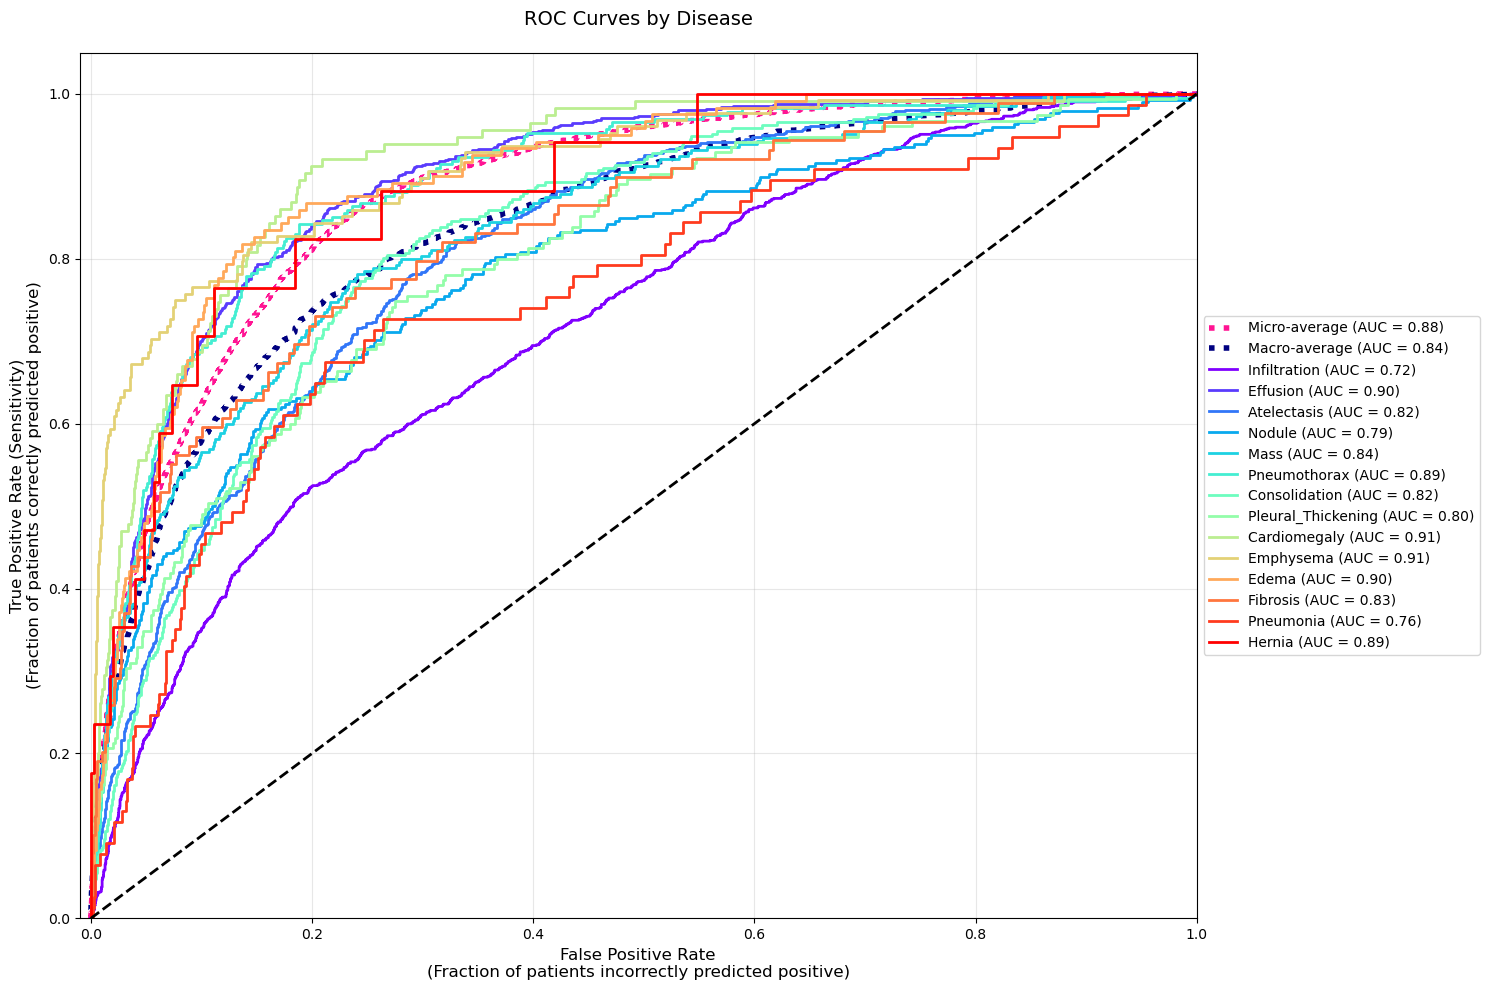

In [14]:
import matplotlib.pyplot as plt

def plot_roc_curves(y_pred_probs, y_true, label_text):
   """Plot ROC curves with disease names and AUC scores
   
   Parameters:
   -----------
   y_pred_probs : array-like
       Predicted probabilities from the ensemble model
   y_true : array-like  
       True binary labels
   label_text : list
       List of disease names
   """
   n_classes = y_true.shape[1]
   
   # Compute ROC curve and ROC AUC for each class
   fpr = dict()
   tpr = dict()
   roc_auc = dict()
   
   # Calculate ROC curves for each disease
   for i in range(n_classes):
       fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
       roc_auc[i] = auc(fpr[i], tpr[i])
   
   # Compute micro-average ROC curve and ROC AUC
   fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
   roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
   
   # Compute macro-average ROC curve and ROC AUC
   all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
   mean_tpr = np.zeros_like(all_fpr)
   for i in range(n_classes):
       mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
   mean_tpr /= n_classes
   
   fpr["macro"] = all_fpr
   tpr["macro"] = mean_tpr
   roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
   
   # Create figure
   plt.figure(figsize=(15, 10))
   
   # Plot micro and macro average curves
   plt.plot(fpr["micro"], tpr["micro"],
           label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
           color='deeppink', linestyle=':', linewidth=4)
   
   plt.plot(fpr["macro"], tpr["macro"],
           label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
           color='navy', linestyle=':', linewidth=4)
   
   # Plot ROC curves for each disease
   colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
   for i, (color, disease) in enumerate(zip(colors, label_text)):
       plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label=f'{disease} (AUC = {roc_auc[i]:.2f})')
   
   # Plot diagonal line
   plt.plot([0, 1], [0, 1], 'k--', lw=2)
   
   # Configure plot
   plt.xlim([-0.01, 1.0])
   plt.ylim([0.0, 1.05])
   plt.xlabel('False Positive Rate\n(Fraction of patients incorrectly predicted positive)', fontsize=12)
   plt.ylabel('True Positive Rate (Sensitivity)\n(Fraction of patients correctly predicted positive)', fontsize=12)
   plt.title('ROC Curves by Disease', fontsize=14, pad=20)
   
   # Adjust legend
   plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
   
   # Save and show plot
   plt.tight_layout()
   plt.grid(True, alpha=0.3)
   plt.savefig('model_statistics/ROC_curves.png', dpi='figure', format='png')
   plt.show()
   plt.close()

# Plot ROC curves using ensemble predictions
plot_roc_curves(ensemble_predictions, true_labels, label_text)

In [13]:
# End timer
end_time = time.time()
elapsed_time = end_time - start_time

# Convert elapsed time to hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Notebook executed in {hours} hours, {minutes} minutes, and {seconds} seconds.")

Notebook executed in 0 hours, 4 minutes, and 17 seconds.
